In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

Bringing in Data from Sqlite Datatbase. 



In [2]:
conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

In [3]:
c.execute('''SELECT * FROM grade_distributions JOIN sections using (course_offering_uuid) JOIN schedules on sections.schedule_uuid = schedules.uuid''')
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.shape

(2077516, 33)

Cleaning up the dataframe

In [4]:
df_dropped = df.drop(columns=['mon', 'tues', 'wed', 'thurs', 'fri','uuid', 'other_count', 'sat','sun','room_uuid', 'section_number', 'n_count', 'p_count', 'nw_count', 'u_count', 's_count', 'i_count', 'nr_count', 'number', 'schedule_uuid', 'end_time'], axis=1)

In [5]:
df_dropped.head()

,course_offering_uuid,c_count,f_count,cr_count,bc_count,d_count,ab_count,a_count,b_count,section_type,start_time
0,344b3ebe-da7e-314c-83ed-9425269695fd,0,0,0,0,0,0,105,0,FLD,-1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,0,0,0,0,0,0,158,0,FLD,-1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1
3,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1
4,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1


Transforming the Start Time into hours.

In [6]:
df_dropped["start_time"] = df_dropped["start_time"].apply(
    lambda x: int(x) / 60
)
df_dropped = df_dropped.dropna()
sorted(pd.unique(df_dropped["start_time"]))

[-0.016666666666666666,
 0.5,
 1.1666666666666667,
 2.5,
 5.5,
 6.0,
 6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12

Removed start times that start before 6:00 AM

In [7]:
df_dropped = df_dropped.loc[df_dropped["start_time"] > 6]
sorted(pd.unique(df_dropped["start_time"]))

[6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.166666666666666,
 12.25,
 12.333333333333334,
 

Created a new column that shows what hour each class started within

In [8]:
df_dropped["hour_within"] = df_dropped["start_time"].apply(lambda x: x // 1)

In [9]:
df_dropped.head()

,course_offering_uuid,c_count,f_count,cr_count,bc_count,d_count,ab_count,a_count,b_count,section_type,start_time,hour_within
165,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,46,0,LAB,8.833333,8.0
166,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,41,0,LAB,8.833333,8.0
167,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,5,13,1,LAB,8.833333,8.0
168,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,6,11,2,LAB,8.833333,8.0
169,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,46,0,LAB,11.000000,11.0


In [10]:
important_grades = [
    "f_count",
    "d_count",
    "c_count",
    "bc_count",
    "b_count",
    "ab_count",
    "a_count",
]

# course_offering_uuid is needed for a later join
df_dropped = df_dropped[[*important_grades, "start_time", "course_offering_uuid"]]
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766724 entries, 165 to 2077513
Data columns (total 9 columns):
f_count                 766724 non-null object
d_count                 766724 non-null object
c_count                 766724 non-null object
bc_count                766724 non-null object
b_count                 766724 non-null object
ab_count                766724 non-null object
a_count                 766724 non-null object
start_time              766724 non-null float64
course_offering_uuid    766724 non-null object
dtypes: float64(1), object(8)
memory usage: 58.5+ MB


Converted the grades from objects to floats

In [11]:
df_dropped[important_grades] = df_dropped[important_grades].apply(lambda x: pd.to_numeric(x))
df_dropped = df_dropped.dropna()


Turned grades into an average GPA for the class and ratio for each grade

In [12]:
grades = df_dropped[important_grades].copy()
df_dropped["total"] = grades.sum(axis=1)
important_grades_ratios = list(map(lambda x: x + "_ratio", important_grades))
df_dropped[important_grades_ratios] = grades[important_grades].apply(lambda x: x / df_dropped["total"])

In [13]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df_dropped["gpa"] = df_dropped[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

In [14]:
df_dropped["hour_within"] = df_dropped["start_time"].apply(lambda x: x // 1)

In [15]:
df_dropped.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
165,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
166,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
167,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
168,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
169,0,0,0,0,0,0,46,11.000000,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,11.0


In [16]:
# df_dropped = df_dropped[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [17]:
df_dropped.shape

(766724, 19)

In [18]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df_dropped["gpa"] = df_dropped[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

In [19]:
gpa_within_hour = df_dropped[["gpa", "hour_within"]].groupby("hour_within") 

Isolated all the classes that start within the hour of 8:00 AM

In [20]:
df_8 = df_dropped.loc[df_dropped["hour_within"] == 8]

In [21]:
df_8.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
165,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
166,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
167,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
168,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
336,0,0,0,0,0,2,23,8.833333,cb14977e-d147-3110-8bf0-83c363730609,25,0.0,0.0,0.0,0.0,0.000000,0.080000,0.920000,3.960000,8.0


Isolated all the classes that start within the hour of 1:00 PM

In [22]:
df_2 = df_dropped.loc[df_dropped["hour_within"] == 13]

In [23]:
df_2.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
173,0,0,0,0,0,0,46,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,13.0
174,0,0,0,0,0,0,41,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,13.0
175,0,0,0,0,1,5,13,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,13.0
176,0,0,0,0,2,6,11,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,13.0
181,0,0,0,0,0,2,38,13.333333,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,40,0.0,0.0,0.0,0.0,0.000000,0.050000,0.950000,3.975000,13.0


In [24]:
# df_1 = df_1[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [25]:
df_2.describe()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
count,123270.000000,123270.00000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,123270.0
mean,0.672191,1.37357,5.066083,4.744561,12.446281,9.790549,15.200089,13.250758,49.293324,0.008920,0.014261,0.056786,0.068923,0.221735,0.228909,0.400467,3.368394,13.0
std,2.088344,4.11415,12.872938,10.723963,24.166786,16.560322,27.843329,0.155317,80.416239,0.022771,0.030250,0.077460,0.077348,0.164511,0.157965,0.268250,0.375679,0.0
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.208333,13.0
25%,0.000000,0.00000,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.111111,0.200000,3.103448,13.0
50%,0.000000,0.00000,0.000000,1.000000,4.000000,5.000000,7.000000,13.333333,19.000000,0.000000,0.000000,0.011494,0.052239,0.222222,0.210526,0.315789,3.352564,13.0
75%,0.000000,1.00000,2.000000,3.000000,9.000000,9.000000,16.000000,13.333333,35.000000,0.000000,0.013158,0.090909,0.116788,0.318182,0.333333,0.555556,3.666667,13.0
max,37.000000,62.00000,139.000000,125.000000,219.000000,234.000000,704.000000,13.916667,716.000000,0.500000,0.545455,1.000000,0.555556,1.000000,1.000000,1.000000,4.000000,13.0


In [26]:
df_2['gpa'].describe()

count    113047.000000
mean          3.368394
std           0.375679
min           1.208333
25%           3.103448
50%           3.352564
75%           3.666667
max           4.000000
Name: gpa, dtype: float64

In [27]:
# df_8 = df_8[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [28]:
df_8['gpa'].describe()

count    80187.000000
mean         3.371119
std          0.384760
min          1.000000
25%          3.099206
50%          3.346154
75%          3.678571
max          4.000000
Name: gpa, dtype: float64

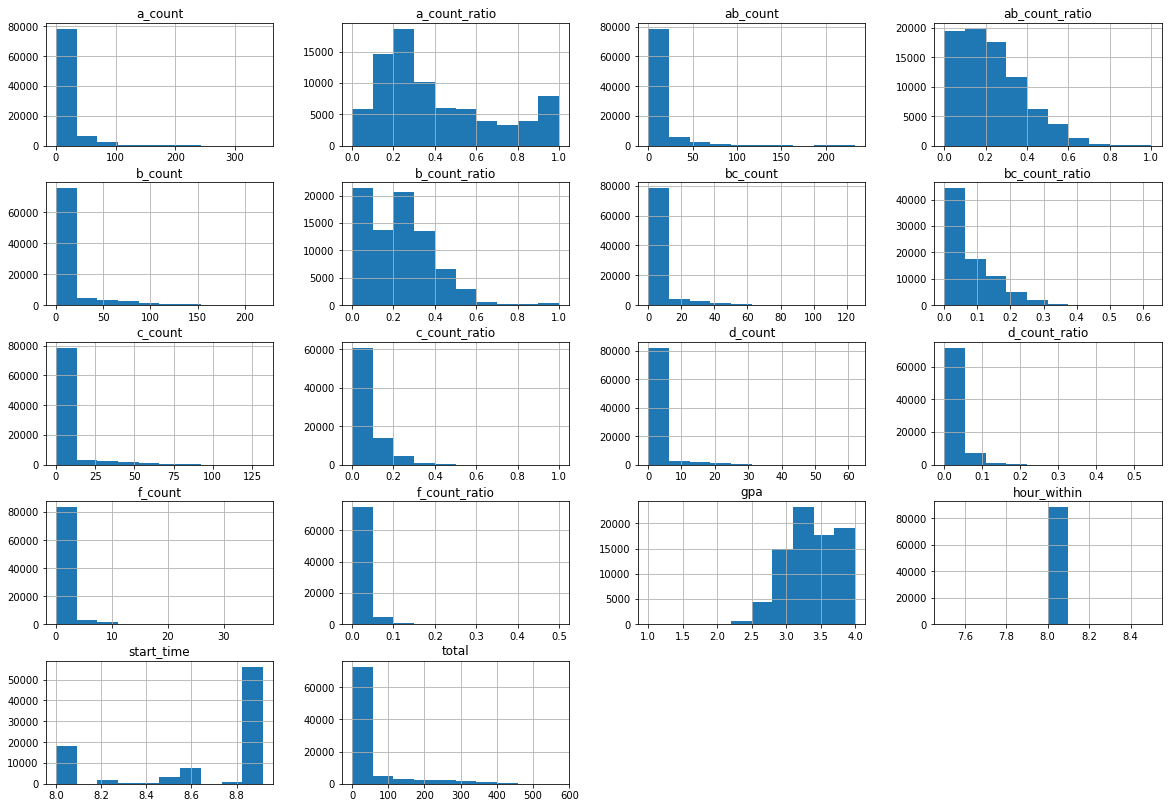

In [29]:
%matplotlib inline

df_8.hist(bins=10, figsize  = [20, 14])
plt.title('Grades for 8:00 AM Classes')
plt.show()

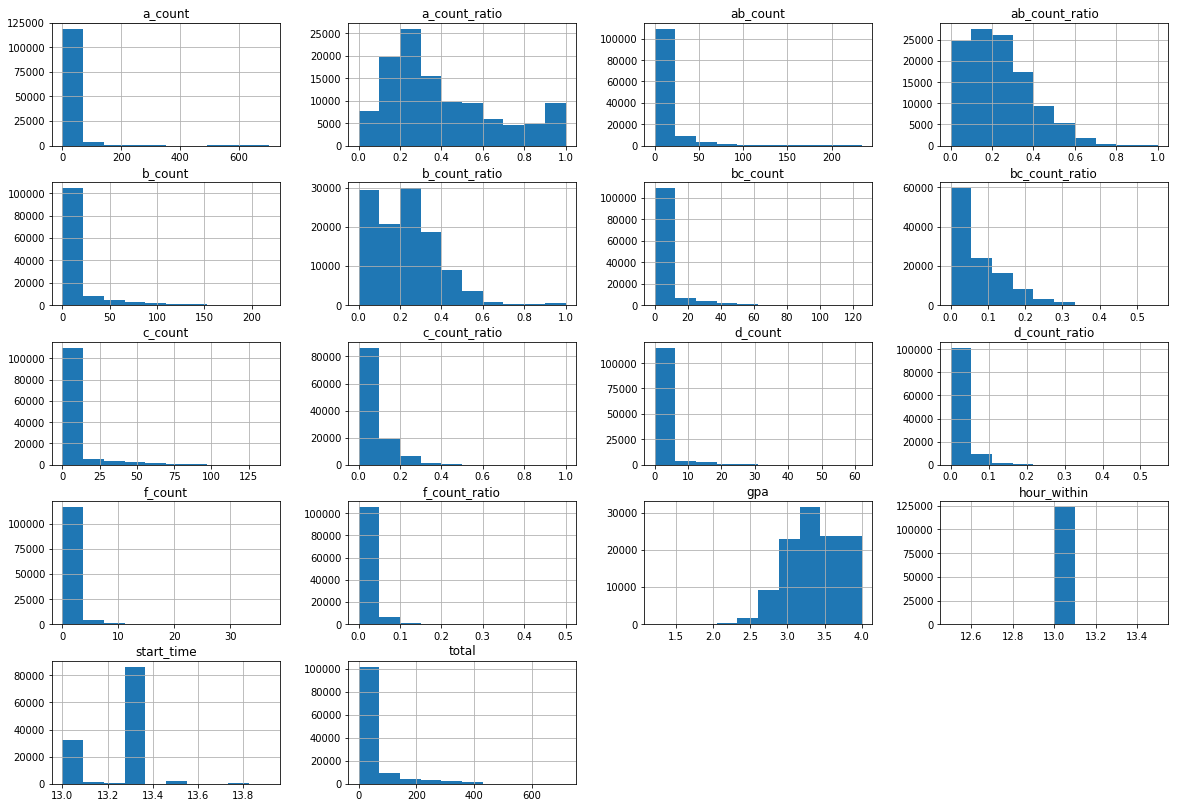

In [30]:
%matplotlib inline

df_2.hist(bins=10, figsize  = [20, 14])
plt.title('Grades for 1:00 PM Classes')
plt.show()

In [31]:
pass_fail_ratio_1 = (df_2.f_count_ratio.sum() + df_2.d_count_ratio.sum()) / (df_2.a_count_ratio.sum() + df_2.ab_count_ratio.sum() + df_2.b_count_ratio.sum() + df_2.bc_count_ratio.sum() + df_2.c_count_ratio.sum() + df_2.d_count_ratio.sum() + df_2.f_count_ratio.sum())


In [32]:
pass_fail_ratio_8 = (df_8.f_count_ratio.sum() + df_8.d_count_ratio.sum()) / (df_8.a_count_ratio.sum() + df_8.ab_count_ratio.sum() + df_8.b_count_ratio.sum() + df_8.bc_count_ratio.sum() + df_8.c_count_ratio.sum() + df_8.d_count_ratio.sum() + df_8.f_count_ratio.sum())


In [33]:
pass_fail_ratio_1

0.023180483365384207

In [34]:
pass_fail_ratio_8

0.0226003779895223

In [35]:
df_2.describe().loc['mean']

f_count            0.672191
d_count            1.373570
c_count            5.066083
bc_count           4.744561
b_count           12.446281
ab_count           9.790549
a_count           15.200089
start_time        13.250758
total             49.293324
f_count_ratio      0.008920
d_count_ratio      0.014261
c_count_ratio      0.056786
bc_count_ratio     0.068923
b_count_ratio      0.221735
ab_count_ratio     0.228909
a_count_ratio      0.400467
gpa                3.368394
hour_within       13.000000
Name: mean, dtype: float64

In [36]:
df_8.describe().loc['mean']

f_count            0.663113
d_count            1.423656
c_count            5.291930
bc_count           4.921381
b_count           12.295020
ab_count           9.361177
a_count           14.353537
start_time         8.612979
total             48.309813
f_count_ratio      0.008479
d_count_ratio      0.014121
c_count_ratio      0.057993
bc_count_ratio     0.068289
b_count_ratio      0.223400
ab_count_ratio     0.221563
a_count_ratio      0.406155
gpa                3.371119
hour_within        8.000000
Name: mean, dtype: float64

In [37]:
df_dropped_2 = df_2[['f_count_ratio', 'd_count_ratio', 'c_count_ratio','bc_count_ratio','b_count_ratio','ab_count_ratio', 'a_count_ratio']]

Text(0.5, 1.0, 'Grade Percentage for 1:00 PM Classes')

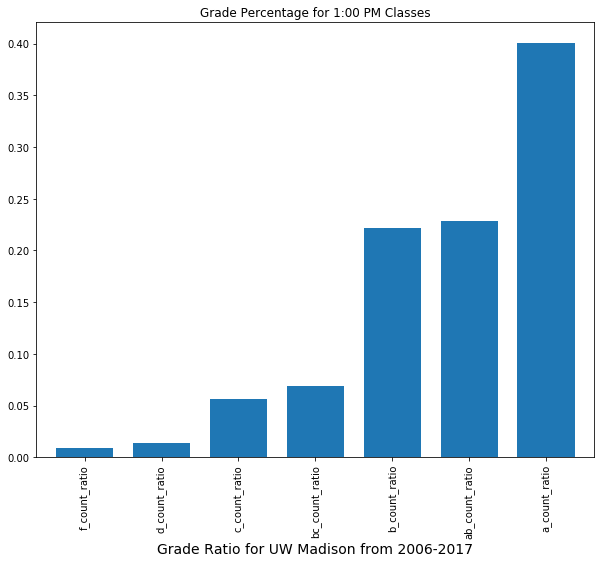

In [38]:
df_dropped_2.describe().loc['mean'].plot.bar(width = 0.75, figsize = (10,8))
plt.xlabel('Grade Ratio for UW Madison from 2006-2017',fontsize=14)
plt.title('Grade Percentage for 1:00 PM Classes')

In [39]:
df_dropped_8 = df_8[['f_count_ratio', 'd_count_ratio', 'c_count_ratio','bc_count_ratio','b_count_ratio','ab_count_ratio', 'a_count_ratio']]

Text(0.5, 1.0, 'Grade Percentage for 8:00 AM Classes')

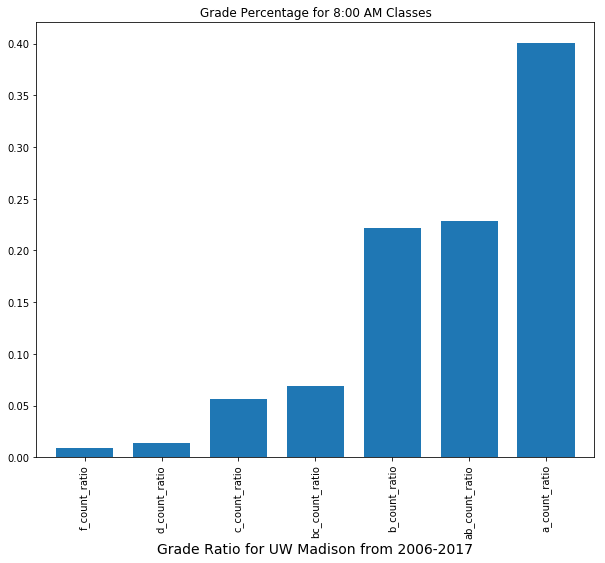

In [40]:
df_dropped_2.describe().loc['mean'].plot.bar(width = 0.75, figsize = (10,8))
plt.xlabel('Grade Ratio for UW Madison from 2006-2017',fontsize=14)
plt.title('Grade Percentage for 8:00 AM Classes')

Converted F's into an array to run a Z-Test

In [41]:
x1 = df_2['f_count'].as_matrix(columns=None)

In [42]:
x2 = df_8['f_count'].as_matrix(columns=None)

In [43]:
import statsmodels as sm 

In [44]:
sm.stats.weightstats.ztest(x1, x2, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)

(0.9736438374568975, 0.33023341210544765)

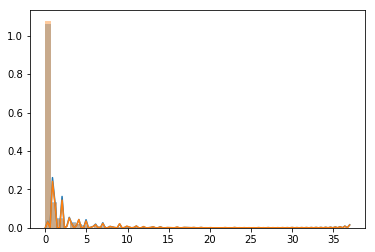

In [45]:
sns.distplot(x1)
sns.distplot(x2)
             
            

Text(0.5, 0, 'Percent Failures')

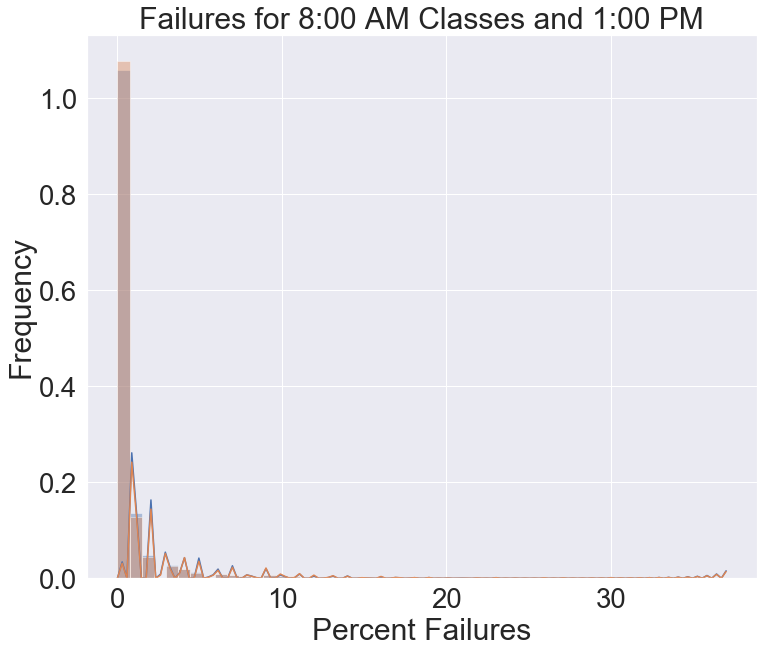

In [46]:
to_graph =  [x1, x2]

#Seaborn distplot of room 2170 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(12,10))
for graph in to_graph:
    sns.distplot(graph,  ax = ax)
    
ax.set_title("Failures for 8:00 AM Classes and 1:00 PM")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent Failures")